# Siemens Energy Coding Challenge - Task 2 - 2021 - Sam MacIntyre

This jupyter notebook contains the code related to task 1, the jupyter notebook follows the structure below:

- Task outline
- Environment and version control
- Problem approach
- Data and library loading
- Data exploration and summary statistics
- Temporal alignment
- NAN treatment
- Moving average predictions
- Reproduce plots
- Conclusions and discussion

## Task outline

Condition monitoring is crucial to prevent equipment failures, optimize maintenance timing and assess intervention benefits.
In this task you will have to forecast the remaining useful life of the components given their current status at the end of the timeseries.

The data set consists of multiple multivariate time series.
Each time series is from a different engine, but the data can be considered to be from a fleet of engines of the same type.
Each engine starts with different degrees of initial wear and manufacturing variation which is unknown but still considered normal, i.e. not a fault condition.
Each engine operates at similar ambient conditions and evolves towards only one kind of failure.
There are three operational settings that have a substantial effect on engine performance.
These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series.
In the training set, the fault grows in magnitude until system failure.
In the test set, the time series ends some time prior to system failure.
The objective is to predict the number of remaining operational cycles before failure in the test set, i.e. the number of operational cycles after the last cycle that the engine will continue to operate.

The data are provided as a text file with 26 columns of numbers, separated by spaces.
Each row is a snapshot of data taken during a single operational cycle, each column is a different variable.
The columns correspond to:

1)	unit number

2)	time, in cycles

3)	operational setting 1

4)	operational setting 2

5)	operational setting 3

6)	sensor measurement  1

7)	sensor measurement  2
...
26)	sensor measurement  21

You should build a machine learning algorithm able to predict the remaining useful cycles and then try to answer some questions:
1. How would you change your approach if instead of similar ambient conditions we would have six different climates?
2. What if we had an additional possible kind of failure? How would you approach the problem then?

## Environment and version control

A temporary Github repository will be used to employ version control and protect against loss of code. Furthermore, a standard Python3 venv has been set up to ensure a clean and reproducible coding environment.

## Problem approach

- Aim is to **predict** the number of operational cycles (after the last cycle) that the engine will operate until failure
- Assume system failure has been achieved at end of time series in test set

## Data and library loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# Load training dataset
df_train = pd.read_csv('data/Task 2/train_FD001.txt', sep = " ", header = None)

In [10]:
# Load testing dataset
df_test = pd.read_csv('data/Task 2/test_FD001.txt', sep = " ", header = None)

In [23]:
# Explore data
df_test

,unit,time (cycles),O1,O2,O3,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,NaN,NaN
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,NaN,NaN
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,NaN,NaN
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,NaN,NaN


In [17]:
# rename columns
df_train.rename(columns = {0:"unit", 1: "time (cycles)", 2:"O1", 3:"O2", 4:"O3"}, inplace = True)
df_test.rename(columns = {0:"unit", 1: "time (cycles)", 2:"O1", 3:"O2", 4:"O3"}, inplace = True)

In [18]:
df_train.columns

Index([         'unit', 'time (cycles)',            'O1',            'O2',
                  'O3',               5,               6,               7,
                     8,               9,              10,              11,
                    12,              13,              14,              15,
                    16,              17,              18,              19,
                    20,              21,              22,              23,
                    24,              25,              26,              27],
      dtype='object')

In [20]:
df_test

,unit,time (cycles),O1,O2,O3,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,NaN,NaN
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,NaN,NaN
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,NaN,NaN
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,NaN,NaN


In [146]:
df_train.describe()

,unit,time (cycles)_x,O1,O2,O3,5,6,7,8,9,...,20,21,22,23,24,25,26,27,time (cycles)_y,Cycles to failure
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,0.0,0.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,NaN,NaN,216.615724,107.807862
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251,NaN,NaN,50.028600,68.880990
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,NaN,NaN,128.000000,0.000000
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,NaN,NaN,185.000000,51.000000
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,NaN,NaN,207.000000,103.000000
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,NaN,NaN,240.000000,155.000000
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,NaN,NaN,362.000000,361.000000


<AxesSubplot:>

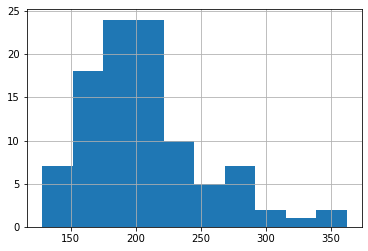

In [30]:
# plot distribution of failure times
df_train.groupby('unit').max()['time (cycles)'].hist()

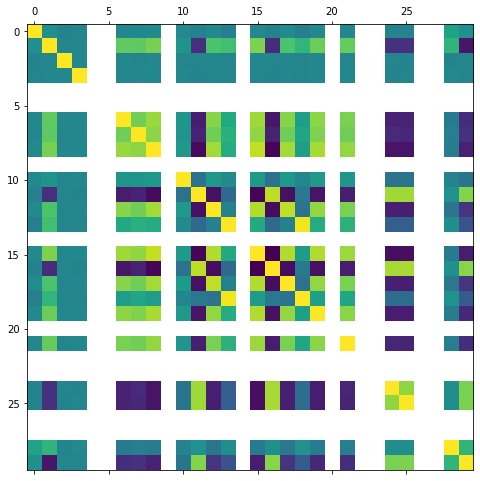

In [125]:
plt.figure(figsize=(8,8))
plt.matshow(df_train.corr(), fignum = 1)
plt.show()

The correlation plot above makes it clear that we have many variables which have no correlation with anything (most likely implying 0 variance as noted above). These should be identified and removed.

### Low/zero variance variable removal

In [151]:
df_train_red = df_train.loc[:, df_train.var() > 0.000000001]

In [152]:
df_train_red.columns

Index([             'unit',   'time (cycles)_x',                'O1',
                      'O2',                   6,                   7,
                         8,                  10,                  11,
                        12,                  13,                  15,
                        16,                  17,                  18,
                        19,                  21,                  24,
                        25,   'time (cycles)_y', 'Cycles to failure'],
      dtype='object')

In [153]:
df_train_red

,unit,time (cycles)_x,O1,O2,6,7,8,10,11,12,...,15,16,17,18,19,21,24,25,time (cycles)_y,Cycles to failure
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,...,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,192,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,...,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,192,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,...,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,192,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,...,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,192,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,...,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,192,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,2388.19,...,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,200,4
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,2388.23,...,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,200,3
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,2388.24,...,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,200,2
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,2388.25,...,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,200,1


In [154]:
df_train_red.corr()

,unit,time (cycles)_x,O1,O2,6,7,8,10,11,12,...,15,16,17,18,19,21,24,25,time (cycles)_y,Cycles to failure
unit,1.000000,0.078753,-0.017895,-0.006197,0.014133,0.012621,0.026116,0.026431,-0.032073,0.039929,...,0.024707,-0.031882,0.044230,-0.059473,0.022486,0.013513,-0.020589,-0.016465,0.216858,0.078753
time (cycles)_x,0.078753,1.000000,-0.004527,0.016132,0.549898,0.543947,0.624577,0.105980,-0.595914,0.475977,...,0.634385,-0.611354,0.477523,0.370324,0.588676,0.566995,-0.583597,-0.585923,0.363152,-0.736241
O1,-0.017895,-0.004527,1.000000,0.011660,0.009030,-0.005651,0.009544,-0.001340,-0.009437,-0.000427,...,0.011658,-0.001491,0.002318,-0.004469,0.007652,0.002599,-0.005713,-0.014559,-0.010636,-0.003198
O2,-0.006197,0.016132,0.011660,1.000000,0.007266,0.009068,0.014673,0.014355,-0.016678,0.013285,...,0.011690,-0.010923,0.018156,-0.006310,0.014156,0.012280,-0.010554,-0.007846,0.019530,-0.001948
6,0.014133,0.549898,0.009030,0.007266,1.000000,0.602610,0.714949,0.132242,-0.702136,0.662325,...,0.740020,-0.724578,0.661792,0.179752,0.675975,0.629886,-0.661841,-0.668050,-0.077909,-0.606484
7,0.012621,0.543947,-0.005651,0.009068,0.602610,1.000000,0.678413,0.116039,-0.664595,0.602481,...,0.695900,-0.680307,0.600963,0.237137,0.639921,0.600017,-0.625941,-0.633901,-0.055863,-0.584520
8,0.026116,0.624577,0.009544,0.014673,0.714949,0.678413,1.000000,0.150480,-0.793130,0.746852,...,0.830136,-0.815591,0.745158,0.190748,0.758459,0.703499,-0.748067,-0.745193,-0.074860,-0.678948
10,0.026431,0.105980,-0.001340,0.014355,0.132242,0.116039,0.150480,1.000000,-0.155720,0.152161,...,0.160014,-0.155884,0.158276,-0.002112,0.149042,0.130810,-0.141419,-0.137419,-0.030798,-0.128348
11,-0.032073,-0.595914,-0.009437,-0.016678,-0.702136,-0.664595,-0.793130,-0.155720,1.000000,-0.767132,...,-0.822805,0.812713,-0.764611,-0.110053,-0.747051,-0.692893,0.736163,0.737447,0.084412,0.657223
12,0.039929,0.475977,-0.000427,0.013285,0.662325,0.602481,0.746852,0.152161,-0.767132,1.000000,...,0.782213,-0.786540,0.826084,-0.144787,0.700949,0.627785,-0.687030,-0.688840,-0.121149,-0.563968


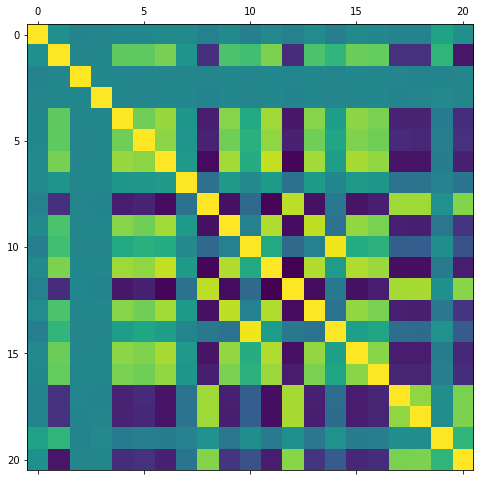

In [155]:
plt.figure(figsize=(8,8))
plt.matshow(df_train_red.corr(), fignum = 1)
plt.show()

In [156]:
df_train_red.drop(['time (cycles)_y', 'Cycles to failure', 'unit'], axis = 1, inplace = True)

/Users/sammacintyre/Documents/Careers/Analysis Tasks/Siemens Energy/sie-2021/siemens-ds-coding-test/venv/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [157]:
df_train_red

,time (cycles)_x,O1,O2,6,7,8,10,11,12,13,15,16,17,18,19,21,24,25
0,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,196,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735
20627,197,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594
20628,198,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333
20629,199,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640


Now we can see that we have correlation values across the whole matrix.

## Dimensionality reduction

The problem statement mentioned that there is a significant amount of noise associated with the sensor data. Hence it may be wise to perform dimensionality reduction. PCA (Principal Components Analysis) allows us to do this by identifying which dimensions of the data capture most of the variance in the dataset.

This technique can be particularly useful when we have correlated variables as we appear to above.

In [158]:
# scale dataset
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train = sc.fit_transform(df_train_red)


/Users/sammacintyre/Documents/Careers/Analysis Tasks/Siemens Energy/sie-2021/siemens-ds-coding-test/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/sammacintyre/Documents/Careers/Analysis Tasks/Siemens Energy/sie-2021/siemens-ds-coding-test/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [160]:
from sklearn.decomposition import PCA
 
pca = PCA(0.95)
 
X_train = pca.fit_transform(X_train)
 
explained_variance = pca.explained_variance_ratio_

In [163]:
explained_variance

array([0.52857248, 0.12058445, 0.05624089, 0.05512948, 0.05345438,
       0.0248529 , 0.02288982, 0.02045329, 0.01919953, 0.01700027,
       0.01609811, 0.01415575, 0.01144369])

In [159]:
X_train

array([[-1.56517022, -0.31597968, -1.3729532 , ..., -0.78170979,
         1.34849274,  1.19442705],
       [-1.55065208,  0.87272193, -1.03172035, ..., -0.78170979,
         1.01652793,  1.23692196],
       [-1.53613393, -1.96187421,  1.01567674, ..., -2.07309423,
         0.73989059,  0.50342281],
       ...,
       [ 1.29490444,  0.18693254, -0.00802181, ...,  3.09244354,
        -2.08181033, -3.29248147],
       [ 1.30942258, -0.49885685,  1.01567674, ...,  1.15536688,
        -2.91172236, -2.08507166],
       [ 1.32394073, -1.458962  , -1.71418605, ...,  1.8010591 ,
        -2.46910261, -2.19408035]])

### Create the target variable

To create the target variable, must subtract current cycle from failure cycle

In [32]:
# Create dataframe containing failure cycle for each unit
df_maxes = df_train.groupby('unit').max()['time (cycles)']

In [34]:
# Merge maxes to main_df
df_train = df_train.merge(df_maxes, on = 'unit')

Note that above we have some variables that have 0 variance. These should be removed as they contribute no useful information.

In [36]:
# Calculate target variable
df_train['Cycles to failure'] = df_train['time (cycles)_y'] - df_train['time (cycles)_x']

In [39]:
df_train

,unit,time (cycles)_x,O1,O2,O3,5,6,7,8,9,...,20,21,22,23,24,25,26,27,time (cycles)_y,Cycles to failure
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN,192,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN,192,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN,192,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN,192,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN,192,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,0.03,397,2388,100.0,38.49,22.9735,NaN,NaN,200,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,0.03,395,2388,100.0,38.30,23.1594,NaN,NaN,200,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,0.03,398,2388,100.0,38.44,22.9333,NaN,NaN,200,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,0.03,395,2388,100.0,38.29,23.0640,NaN,NaN,200,1


There are a few things to keep in mind here when it comes to how to model this problem. A simple approach may say that the time to failure can be predicted only based on the current conditions of the engine (no account of past settings or sensor values)

This seems overly simplistic given it is probable that past operating conditions affect the current state and hence future state.

Furthermore, some thought needs to be given to the importance of the difference of each unit. I see two main approaches:

1. Assume unit is irrelevant and the data can be treated as I.I.D (Indpendent and Identically Distributed). This is a relatively valid assumption given the information we have above.
2. Include the unit as a categorical variable, which should capture some of the inherent variation of the engines

On further reflection, I have disregarded the unit category, as this contains random information about the initial state of the engine (things that are not captured by age or other variables). This information is unlikely to be obtainable if we are wanting to make predictions in the future about unknown engines (outside of unit 1 - 100)


## Linear regression

Let's disregard unit specificity for the moment, and fit a simple linear regression forgetting cumulative data, to give us a benchmark model.

In [41]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [105]:
# Drop columns
df_target = df_train['Cycles to failure']

In [106]:
df_features = df_train.drop(['unit', 'time (cycles)_y', 'Cycles to failure', 26, 27], axis = 1)

In [107]:
df_features

,time (cycles)_x,O1,O2,O3,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
0,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [108]:
X = df_features.values # values converts it into a numpy array
Y = df_target.values

In [58]:
len(Y)

20631

In [109]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [110]:
model_LR = LinearRegression()
# fitting the training data
model_LR.fit(X, Y)

LinearRegression()

In [111]:
# Obtain R squared as a measure of fit
r_sq = model_LR.score(X, Y)
print('coefficient of determination:', r_sq)

# Print the Intercept:
print('intercept:', model_LR.intercept_)

# Print the Slope:
print('coefficients:', model_LR.coef_) 

coefficient of determination: 0.6555905297409524
intercept: 125859.99197417423
coefficients: [-3.99640778e-01 -6.14378103e+01  2.43416877e+03  2.35164777e-10
 -6.97915503e-10 -5.32978571e+00 -2.71006100e-01 -4.49405046e-01
 -1.18305366e-12 -4.89501669e+02  4.19807458e+00 -2.72972639e+01
 -1.64408021e-01 -1.38555833e-12 -2.39529116e+01  5.72435199e+00
 -1.96394176e+01 -1.37355741e-01 -7.98539951e+01 -4.07298399e-23
 -9.77215078e-01  0.00000000e+00  0.00000000e+00  9.75703300e+00
  2.43794617e+01]


We have obtained an R^{2} score of 0.66, which is not a particularly good fit.

## Prediction

We have no ground truth available to evaluate the model, but we are still able to use the model to offer a first basic set of predictions.

In [102]:
# Predict a Response and print it:
y_pred = model_LR.predict(X_test)

/Users/sammacintyre/Documents/Careers/Analysis Tasks/Siemens Energy/sie-2021/siemens-ds-coding-test/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [103]:
y_pred

array([137.92469138, 152.11774359, 128.54828058, ...,  56.95094081,
        49.40328722,  16.9523017 ])

## Random Forest

Let's use a Random Forest to predict the survival time of the engine.

This time, we will use an 80/20 split on the training set, as this set is the only one that we have a ground truth for.

In [164]:
df_train_red

,time (cycles)_x,O1,O2,6,7,8,10,11,12,13,15,16,17,18,19,21,24,25
0,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,196,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735
20627,197,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594
20628,198,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333
20629,199,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640


In [165]:
df_target

0        191
1        190
2        189
3        188
4        187
        ... 
20626      4
20627      3
20628      2
20629      1
20630      0
Name: Cycles to failure, Length: 20631, dtype: int64

In [166]:
df_train_red_vals = df_train_red.values

In [167]:
df_train_red_vals

array([[ 1.00000e+00, -7.00000e-04, -4.00000e-04, ...,  3.92000e+02,
         3.90600e+01,  2.34190e+01],
       [ 2.00000e+00,  1.90000e-03, -3.00000e-04, ...,  3.92000e+02,
         3.90000e+01,  2.34236e+01],
       [ 3.00000e+00, -4.30000e-03,  3.00000e-04, ...,  3.90000e+02,
         3.89500e+01,  2.33442e+01],
       ...,
       [ 1.98000e+02,  4.00000e-04,  0.00000e+00, ...,  3.98000e+02,
         3.84400e+01,  2.29333e+01],
       [ 1.99000e+02, -1.10000e-03,  3.00000e-04, ...,  3.95000e+02,
         3.82900e+01,  2.30640e+01],
       [ 2.00000e+02, -3.20000e-03, -5.00000e-04, ...,  3.96000e+02,
         3.83700e+01,  2.30522e+01]])

In [169]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(df_train_red_vals, Y, test_size = 0.2, random_state = 42)

In [170]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (16504, 18)
Training Labels Shape: (16504,)
Testing Features Shape: (4127, 18)
Testing Labels Shape: (4127,)


In [171]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [173]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 25.34
